In [ ]:
pip install mplsoccer

In [ ]:
pip install cmasher

In [ ]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch
from matplotlib.font_manager import FontProperties
from mplsoccer import Pitch, FontManager, Sbopen
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import cmasher as cmr
from mplsoccer import VerticalPitch, Sbopen
from mplsoccer.utils import FontManager


# EventDataScraping

---



In [ ]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

match_html_path = '/content/PSV Eindhoven 1-1 Arsenal - Champions League 2023_2024 Live.html'
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)

df.to_csv('EventData.csv')
df = pd.read_csv('/content/EventData.csv')
dfp.to_csv('PlayerData.csv')
dfp = pd.read_csv('/content/PlayerData.csv')

In [ ]:
# Extract the 'displayName' value
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

# Reshaping the data from 100x100 to 80x120
df['x'] = df['x']*1.2
df['y'] = df['y']*0.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*0.8
df['goalMouthY'] = df['goalMouthY']*0.8
df['goalMouthZ'] = df['goalMouthZ']*0.116

# Function to extract only text from a dictionary value
def extract_text(value):
    # Convert the value to a string if it's not already
    if not isinstance(value, str):
        value = str(value)
    # Use regex to remove all non-alphabetic characters
    return re.sub(r'[^A-Za-z]+', '', value)

# Apply the function to the 'value' column in the DataFrame
df['qualifiers'] = df['qualifiers'].apply(extract_text)

df = df.merge(dfp, on='playerId', how='left')

# Calculating passing distance, to find out progressive pass
df['pro'] = np.where((df['type'] == 'Pass') & (df['outcomeType'] == 'Successful') & (df['x'] > 48),
                            np.sqrt((120 - df['x'])**2 + (40 - df['y'])**2) - np.sqrt((120 - df['endX'])**2 + (40 - df['endY'])**2),
                            0)
# converting the x values to y values and vice versa
df['x'], df['y'] = df['y'].values, df['x'].values
df['endX'], df['endY'] = df['endY'].values, df['endX'].values

# Print the modified DataFrame
pd.set_option('display.max_columns', None)

print(df)

In [ ]:
hteamID=129
ateamID=13
hteamName= "PSV"
ateamName= "Arsenal"

In [ ]:
df.to_csv('psvars.csv')
from google.colab import files
files.download('psvars.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Pass Network

---



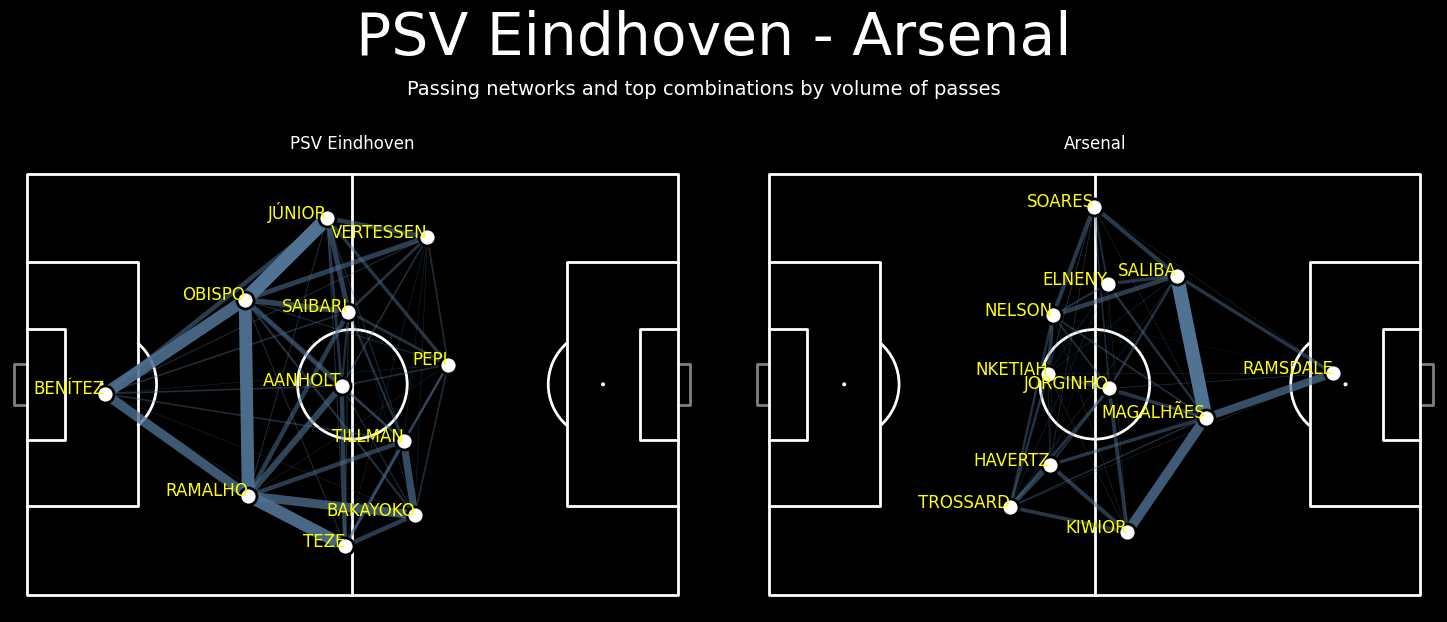

In [ ]:
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes

passes_df = get_passes_df(events_dict)

def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df

home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)

def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 750
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    # average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
    #                                             / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', goal_type='box', goal_alpha=.5, pitch_color='#000000', line_color='#ffffff')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=150, marker='o',
                               color='#ffffff', edgecolor='black', linewidth=2, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        player_name = row["name"].split()[-1]
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='#ffff00', ha='right',
                        size=12, ax=ax)

    return pitch

# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#000000")

# plot variables
main_color = '#ffffff'
# font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
#                          "RobotoCondensed-Medium.ttf?raw=true"))

# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id], color=main_color)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color)

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)
# plt.savefig('output.png', bbox_inches='tight')
plt.show()

# ShotMap (withxG)

---




In [ ]:
base_url = 'https://understat.com/match/'
match = str(input('Please enter the match id: '))
url = base_url+match

In [ ]:
res = requests.get(url)
soup = BeautifulSoup(res.content, "lxml")
scripts = soup.find_all('script')

string_with_json_obj = ''
# Find data for teams
for el in scripts:
    if 'shotsData' in el.text:
        string_with_json_obj = el.text.strip()
#print(string_with_json_obj)

# strip unnecessary symbols and get only JSON data
ind_start = string_with_json_obj.index("('")+2
ind_end = string_with_json_obj.index("')")
json_data = string_with_json_obj[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')

#convert string to json format
data = json.loads(json_data)

In [ ]:
#Create Dataframe
x_under = []
y_under = []
min_under = []
result_under = []
xG_under = []
player_under = []
team_under = []
dataa = data['a']
datah = data['h']
names = ['x','y','minute','team','xG','player','result']

for index in range(len(datah)):
    for key in datah[index]:
        if key == 'X':
            x_under.append(datah[index][key])
        if key == 'Y':
            y_under.append(datah[index][key])
        if key == 'minute':
            min_under.append(datah[index][key])
        if key == 'h_team':
            team_under.append(datah[index][key])
        if key == 'xG':
            xG_under.append(datah[index][key])
        if key == 'player':
            player_under.append(datah[index][key])
        if key == 'result':
            result_under.append(datah[index][key])

for index in range(len(dataa)):
    for key in dataa[index]:
        if key == 'X':
            x_under.append(1 - float(dataa[index][key]))
        if key == 'Y':
            y_under.append(1 - float(dataa[index][key]))
        if key == 'minute':
            min_under.append(dataa[index][key])
        if key == 'a_team':
            team_under.append(dataa[index][key])
        if key == 'xG':
            xG_under.append(dataa[index][key])
        if key == 'player':
            player_under.append(dataa[index][key])
        if key == 'result':
            result_under.append(dataa[index][key])

In [ ]:
df2 = pd.DataFrame([x_under,y_under,min_under,team_under,xG_under,player_under,result_under],index=names)
df2 = df2.T

df2['x'] = pd.to_numeric(df2['x'])
df2['y'] = pd.to_numeric(df2['y'])
df2['xG'] = pd.to_numeric(df2['xG'])
df2['minute'] = pd.to_numeric(df2['minute'])

df2['x'] = df2['x']*100
df2['y'] = df2['y']*100

df2['xx'] = df2['y']
df2['yy'] = df2['x']

df2['x'] = df2['xx']
df2['y'] = df2['yy']

df2['x'] = df2['x']*.8
df2['y'] = df2['y']*1.2

hteam = df2['team'].iloc[0]
ateam = df2['team'].iloc[-1]

In [ ]:
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]

for x in range(len(df2['xG'])):
    if df2['team'][x] == ateam:
        a_xG.append(df2['xG'][x])
        a_min.append(df2['minute'][x])
    if df2['team'][x] == hteam:
        h_xG.append(df2['xG'][x])
        h_min.append(df2['minute'][x])

def nums_cumulative_sum(nums_list):
  return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

acum = nums_cumulative_sum(a_xG)
hcum = nums_cumulative_sum(h_xG)
alast = round(acum[-1],2)
hlast = round(hcum[-1],2)

In [ ]:
df2['xx'] = df2['xx']*1.2
df2['yy'] = df2['yy']*0.8

In [ ]:
df2

,x,y,minute,team,xG,player,result,xx,yy
0,58.959998,104.880002,10,Barcelona,0.030957,João Félix,MissedShots,88.439996,69.920001
1,51.200000,110.519998,16,Barcelona,0.362973,Robert Lewandowski,SavedShot,76.800000,73.679999
2,33.520001,115.560004,20,Barcelona,0.403457,Fermín López,MissedShots,50.280002,77.040002
3,59.120001,89.519998,22,Barcelona,0.016403,João Félix,SavedShot,88.680002,59.679999
4,57.040002,97.200000,47,Barcelona,0.018824,João Cancelo,SavedShot,85.560004,64.800000
5,37.279999,107.160004,52,Barcelona,0.076059,Robert Lewandowski,Goal,55.919998,71.440002
6,54.559998,101.880002,55,Barcelona,0.065241,João Félix,MissedShots,81.839996,67.920001
7,51.920001,92.639996,58,Barcelona,0.025542,João Félix,MissedShots,77.880002,61.759998
8,23.920000,105.480002,71,Barcelona,0.040669,Lamine Yamal,SavedShot,35.880000,70.320001
9,38.079999,92.639996,74,Barcelona,0.027989,Raphinha,MissedShots,57.119998,61.759998


In [ ]:
df2.to_csv('fcbalaShots.csv')
from google.colab import files
files.download('fcbalaShots.csv')

Text(84, 16, 'xG: 1.84')

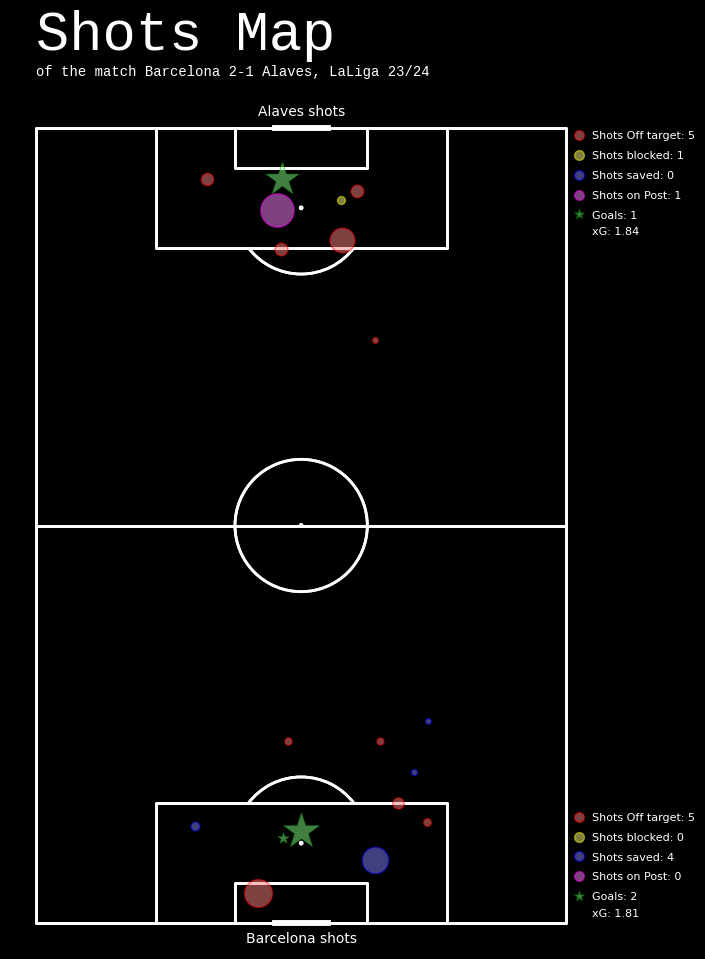

In [ ]:
# Calculate the total xG for hteam and ateam
hteam_xG = df2[df2['team'] == 'Barcelona']['xG'].sum()
ateam_xG = df2[df2['team'] == 'Alaves']['xG'].sum()

def plotShotMap():
    hgoal = 0
    hpost = 0
    hsaved = 0
    hblocked = 0
    hmissed = 0
    agoal = 0
    apost = 0
    asaved = 0
    ablocked = 0
    amissed = 0
    for x in range(len(df2['x'])):
        if df2['team'][x] == ateam:
            if df2['result'][x] == 'Goal':
                plt.scatter(df2['x'][x],df2['y'][x], color = '#80ff80',s=df2['xG'][x]*1000,edgecolor='green',linewidth=0.5,alpha=0.5,marker='*')
                agoal += 1
            if df2['result'][x] == 'ShotOnPost':
                plt.scatter(df2['x'][x],df2['y'][x], color = '#ff80ff',s=df2['xG'][x]*1000,edgecolor='magenta',alpha=0.5)
                apost += 1
            if df2['result'][x] == 'SavedShot':
                plt.scatter(df2['x'][x],df2['y'][x], color = '#8080ff',s=df2['xG'][x]*1000,edgecolor='blue',alpha=0.5)
                asaved += 1
            if df2['result'][x] == 'BlockedShot':
                plt.scatter(df2['x'][x],df2['y'][x], color = '#ffff80',s=df2['xG'][x]*1000,edgecolor='yellow',alpha=0.5)
                ablocked += 1
            if df2['result'][x] == 'MissedShots':
                plt.scatter(df2['x'][x],df2['y'][x], color = '#ff8080',s=df2['xG'][x]*1000,edgecolor='red',alpha=0.5)
                amissed += 1

        if df2['team'][x] == hteam:
            if df2['result'][x] == 'Goal':
                plt.scatter(df2['x'][x],df2['y'][x], color = '#80ff80',s=df2['xG'][x]*1000,edgecolor='green',linewidth=0.5,alpha=0.5,marker='*')
                hgoal += 1
            if df2['result'][x] == 'ShotOnPost':
                plt.scatter(df2['x'][x],df2['y'][x], color = '#ff80ff',s=df2['xG'][x]*1000,edgecolor='magenta',alpha=0.5)
                hpost += 1
            if df2['result'][x] == 'SavedShot':
                plt.scatter(df2['x'][x],df2['y'][x], color = '#8080ff',s=df2['xG'][x]*1000,edgecolor='blue',alpha=0.5)
                hsaved += 1
            if df2['result'][x] == 'BlockedShot':
                plt.scatter(df2['x'][x],df2['y'][x], color = '#ffff80',s=df2['xG'][x]*1000,edgecolor='yellow',alpha=0.5)
                hblocked += 1
            if df2['result'][x] == 'MissedShots':
                plt.scatter(df2['x'][x],df2['y'][x], color = '#ff8080',s=df2['xG'][x]*1000,edgecolor='red',alpha=0.5)
                hmissed += 1

    return hgoal, hpost, hsaved, hblocked, hmissed, agoal, apost, asaved, ablocked, amissed

# Set up the pitch
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#000000', line_color='#ffffff')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#000000')
pitch.draw(ax=ax)
plt.gca().invert_yaxis()

hgoal, hpost, hsaved, hblocked, hmissed, agoal, apost, asaved, ablocked, amissed = plotShotMap()

Title = "Shots Map"
font = FontProperties(family='Liberation Mono', style='normal', size=40)
plt.text(0,-12, Title, fontproperties=font, color='white')
Subtitle = "of the match Barcelona 2-1 Alaves, LaLiga 23/24"
font = FontProperties(family='Liberation Mono', style='normal', size=10)
plt.text(0,-8, Subtitle, fontproperties=font, color='white')
line1= "Alaves shots"
plt.text(40, -2, line1, ha='center', fontsize=10, color='white')
line1= "Barcelona shots"
plt.text(40, 123, line1, ha='center', fontsize=10, color='white')

# Add custom text side the plot for ateam
count_lines = [
    f"Shots Off target: {amissed}",
    f"Shots blocked: {ablocked}",
    f"Shots saved: {asaved}",
    f"Shots on Post: {apost}",
    f"Goals: {agoal}"
]
# Add custom text lines for counts side the plot
y_coordinate = 1.5  # Adjust the y-coordinate as needed
for line in count_lines:
    plt.text(84, y_coordinate, line, fontsize=8, color='white', ha='left')
    y_coordinate += 3

# Add custom text side the plot for hteam
count_lines = [
    f"Shots Off target: {hmissed}",
    f"Shots blocked: {hblocked}",
    f"Shots saved: {hsaved}",
    f"Shots on Post: {hpost}",
    f"Goals: {hgoal}"
]
# Add custom text lines for counts side the plot
y_coordinate = 104.5  # Adjust the y-coordinate as needed
for line in count_lines:
    plt.text(84, y_coordinate, line, fontsize=8, color='white', ha='left')
    y_coordinate += 3

plt.scatter(82, 1, color = '#ff8080',s=50,edgecolor='red',alpha=0.5)
plt.scatter(82, 4, color = '#ffff80',s=50,edgecolor='yellow',alpha=0.5)
plt.scatter(82, 7, color = '#8080ff',s=50,edgecolor='blue',alpha=0.5)
plt.scatter(82, 10, color = '#ff80ff',s=50,edgecolor='magenta',alpha=0.5)
plt.scatter(82, 13, color = '#80ff80',s=50,edgecolor='green',alpha=0.5, marker='*')
plt.scatter(82, 104, color = '#ff8080',s=50,edgecolor='red',alpha=0.5)
plt.scatter(82, 107, color = '#ffff80',s=50,edgecolor='yellow',alpha=0.5)
plt.scatter(82, 110, color = '#8080ff',s=50,edgecolor='blue',alpha=0.5)
plt.scatter(82, 113, color = '#ff80ff',s=50,edgecolor='magenta',alpha=0.5)
plt.scatter(82, 116, color = '#80ff80',s=50,edgecolor='green',alpha=0.5, marker='*')

hteam_xG_text = f"xG: {hteam_xG:.2f}"
ateam_xG_text = f"xG: {ateam_xG:.2f}"

plt.text(84, 119, hteam_xG_text, fontsize=8, color='white', ha='left')
plt.text(84, 16, ateam_xG_text, fontsize=8, color='white', ha='left')

# xG Flow

---



In [ ]:
dfx = pd.read_csv('/content/fcbalaShots.csv')

In [ ]:
#now that we have our dataframe set up, we are going to create some lists to plot the different xG values
#4 lists - home and away xg and minutes
#We start these with zero so our charts will start at 0
a_xG = [0]
h_xG= [0]
a_min = [0]
h_min = [0]


#this finds our team names from the dataframe. This will only work as long as both teams took a shot
hteam = dfx['team'].iloc[0]
ateam = dfx['team'].iloc[-1]

for x in range(len(dfx['xG'])):
    if dfx['team'][x]==ateam:
        a_xG.append(dfx['xG'][x])
        a_min.append(dfx['minute'][x])
    if dfx['team'][x]==hteam:
        h_xG.append(dfx['xG'][x])
        h_min.append(dfx['minute'][x])

#this is the function we use to make our xG values be cumulative rather than single shot values
#it goes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

#this is used to find the total xG. It just creates a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

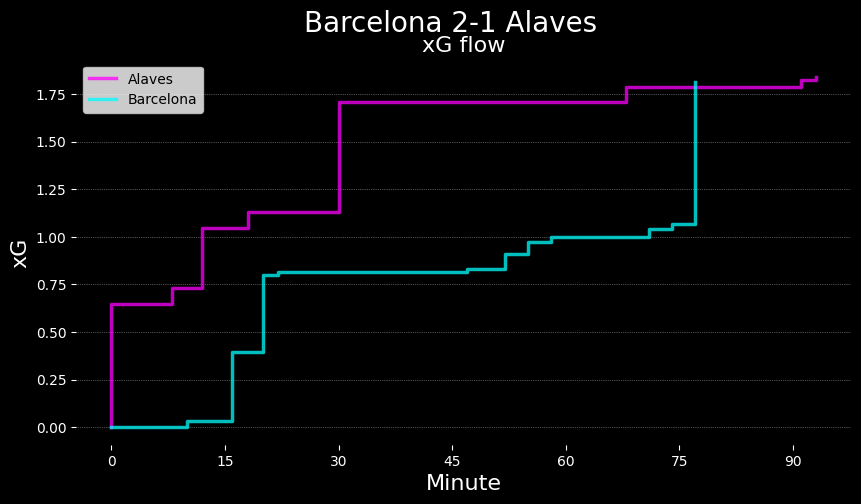

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
fig.set_facecolor('black')
ax.patch.set_facecolor('black')

#set up our base layer
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'

ax.grid(ls='dotted',lw=.5,color='lightgrey',axis='y',zorder=1,alpha=0.75)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)

plt.xticks([0,15,30,45,60,75,90])
plt.xlabel('Minute',color='white',fontsize=16)
plt.ylabel('xG',color='white',fontsize=16)
plt.suptitle('Barcelona 2-1 Alaves', color='white', fontsize=20)
plt.title('xG flow', color='white', fontsize=16)

#plot the step graphs
ax.step(x=a_min,y=a_cumulative,color='magenta',label=ateam,linewidth=2.5,where='post',alpha=0.75)
ax.step(x=h_min,y=h_cumulative,color='cyan',label=hteam,linewidth=2.5,where='post',alpha=0.75)
plt.legend()

# ShotMap

---



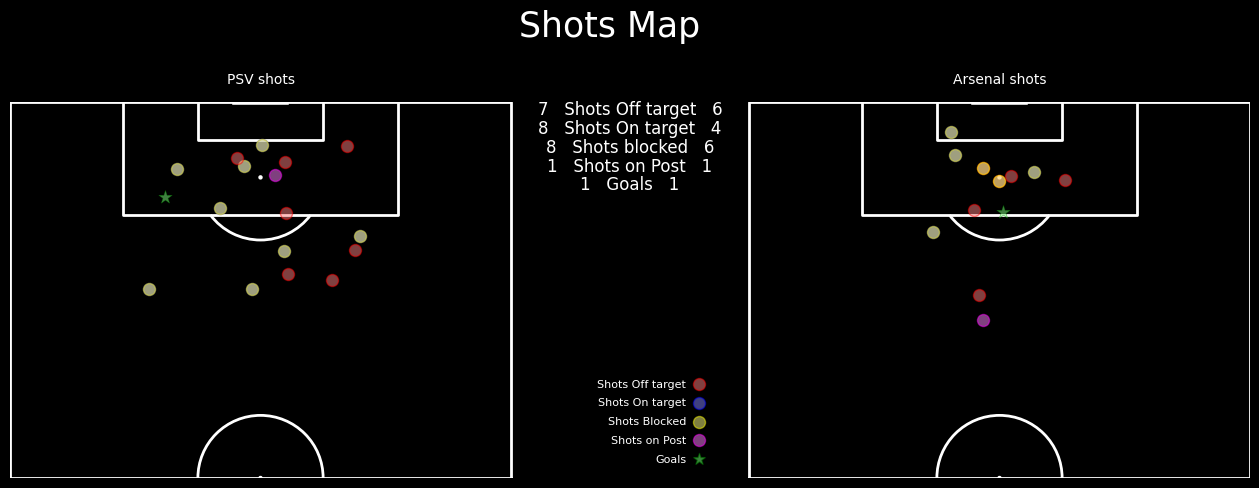

In [ ]:
# Create a figure with a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 11), facecolor='#000000')

# Set up the pitch for the first subplot
pitch1 = VerticalPitch(pitch_type='statsbomb', pitch_color='#000000', line_color='#ffffff')
pitch1.draw(ax=axs[0])
axs[0].set_facecolor('#000000')  # Set the background color
axs[0].set_ylim(60, 120)
axs[0].set_xlim(-10, 80)
axs[0].invert_xaxis()
def plotShotMap1(ax):
    hgoal = 0
    hpost = 0
    hsaved = 0
    hmissed = 0
    hblocked = 0
    for x in range(len(df['x'])):
        if df['teamId_x'][x] == hteamID:
            if df['type'][x] == 'Goal':
                ax.scatter(df['x'][x],df['y'][x], color = '#80ff80',s=100,edgecolor='green',linewidth=0.5,alpha=0.5,marker='*')
                hgoal += 1
            if df['type'][x] == 'ShotOnPost':
                ax.scatter(df['x'][x],df['y'][x], color = '#ff80ff',s=75,edgecolor='magenta',alpha=0.5)
                hpost += 1
            if df['type'][x] == 'SavedShot':
                ax.scatter(df['x'][x],df['y'][x], color = '#8080ff',s=75,edgecolor='blue',alpha=0.5)
                hsaved += 1
            if df['type'][x] == 'MissedShots':
                ax.scatter(df['x'][x],df['y'][x], color = '#ff8080',s=75,edgecolor='red',alpha=0.5)
                hmissed += 1
            if df['type'][x] == 'MissedShots' and df['blockedX'][x] >= 0:
                ax.scatter(df['x'][x],df['y'][x], color = '#ffff80',s=75,edgecolor='yellow',alpha=0.5)
                hblocked += 1
            if df['type'][x] == 'SavedShot' and df['blockedX'][x] >= 0:
                ax.scatter(df['x'][x],df['y'][x], color = '#ffff80',s=75,edgecolor='yellow',alpha=0.5)
                hblocked += 1
    return hgoal, hpost, hsaved, hblocked, hmissed

hgoal, hpost, hsaved, hblocked, hmissed = plotShotMap1(axs[0])

line1 = f"{hteamName} shots"
axs[0].text(40, 123, line1, ha='center', fontsize=10, color='white')

# Set up the pitch for the second subplot
pitch2 = VerticalPitch(pitch_type='statsbomb', pitch_color='#000000', line_color='#ffffff')
pitch2.draw(ax=axs[1])
axs[1].set_facecolor('#000000')  # Set the background color
axs[1].set_ylim(60, 120)
axs[1].set_xlim(0, 90)
axs[1].invert_xaxis()
def plotShotMap2(ax):
    agoal = 0
    apost = 0
    asaved = 0
    amissed = 0
    ablocked = 0
    for x in range(len(df['x'])):
        if df['teamId_x'][x] == ateamID:
            if df['type'][x] == 'Goal':
                ax.scatter(df['x'][x],df['y'][x], color = '#80ff80',s=100,edgecolor='green',linewidth=0.5,alpha=0.5,marker='*')
                agoal += 1
            if df['type'][x] == 'ShotOnPost':
                ax.scatter(df['x'][x],df['y'][x], color = '#ff80ff',s=75,edgecolor='magenta',alpha=0.5)
                apost += 1
            if df['type'][x] == 'SavedShot':
                ax.scatter(df['x'][x],df['y'][x], color = '#8080ff',s=75,edgecolor='blue',alpha=0.5)
                asaved += 1
            if df['type'][x] == 'MissedShots':
                ax.scatter(df['x'][x],df['y'][x], color = '#ff8080',s=75,edgecolor='red',alpha=0.5)
                amissed += 1
            if df['type'][x] == 'MissedShots' and df['blockedX'][x] >= 0:
                ax.scatter(df['x'][x],df['y'][x], color = '#ffff80',s=75,edgecolor='yellow',alpha=0.5)
                ablocked += 1
            if df['type'][x] == 'SavedShot' and df['blockedX'][x] >= 0:
                ax.scatter(df['x'][x],df['y'][x], color = '#ffff80',s=75,edgecolor='yellow',alpha=0.5)
                ablocked += 1
    return agoal, apost, asaved, ablocked, amissed

agoal, apost, asaved, ablocked, amissed = plotShotMap2(axs[1])

line2 = f"{ateamName} shots"
axs[1].text(40, 123, line2, ha='center', fontsize=10, color='white')

# Add custom text side the plot for ateam
count_lines = [
    f"{hmissed}   Shots Off target   {amissed}",
    f"{hsaved}   Shots On target   {asaved}",
    f"{hblocked}   Shots blocked   {ablocked}",
    f"{hpost}   Shots on Post   {apost}",
    f"{hgoal}   Goals   {agoal}"
]
# Add custom text lines for counts side the plot
y_coordinate = 118  # Adjust the y-coordinate as needed
for line in count_lines:
    plt.text(99, y_coordinate, line, fontsize=12, color='white', ha='center')
    y_coordinate -= 3

plt.scatter(88, 75, color = '#ff8080',s=75,edgecolor='red',alpha=0.5)
plt.scatter(88, 72, color = '#8080ff',s=75,edgecolor='blue',alpha=0.5)
plt.scatter(88, 69, color = '#ffff80',s=75,edgecolor='yellow',alpha=0.5)
plt.scatter(88, 66, color = '#ff80ff',s=75,edgecolor='magenta',alpha=0.5)
plt.scatter(88, 63, color = '#80ff80',s=75,edgecolor='green',alpha=0.5, marker='*')
# Add custom text side the plot for ateam
count_lines = [
    f"Shots Off target",
    f"Shots On target",
    f"Shots Blocked",
    f"Shots on Post",
    f"Goals"
]
# Add custom text lines for counts side the plot
y_coordinate =74.5  # Adjust the y-coordinate as needed
for line in count_lines:
    plt.text(90, y_coordinate, line, fontsize=8, color='white', ha='right')
    y_coordinate -= 3

plt.suptitle("Shots Map", fontsize=25, color='white', y=0.75)

# Display the combined plot
plt.show()

#  Teams Progressive Passes

---



In [ ]:
# Create a boolean mask for the condition
mask = df['teamId_x'] == ateamID
# Use the mask to filter the rows
dfapp = df[mask]
dfapp = dfapp.loc[dfapp['type'] == "Pass"]


# Create a boolean mask for the condition
mask = df['teamId_x'] == hteamID
# Use the mask to filter the rows
dfhpp = df[mask]
dfhpp = dfhpp.loc[dfhpp['type'] == "Pass"]

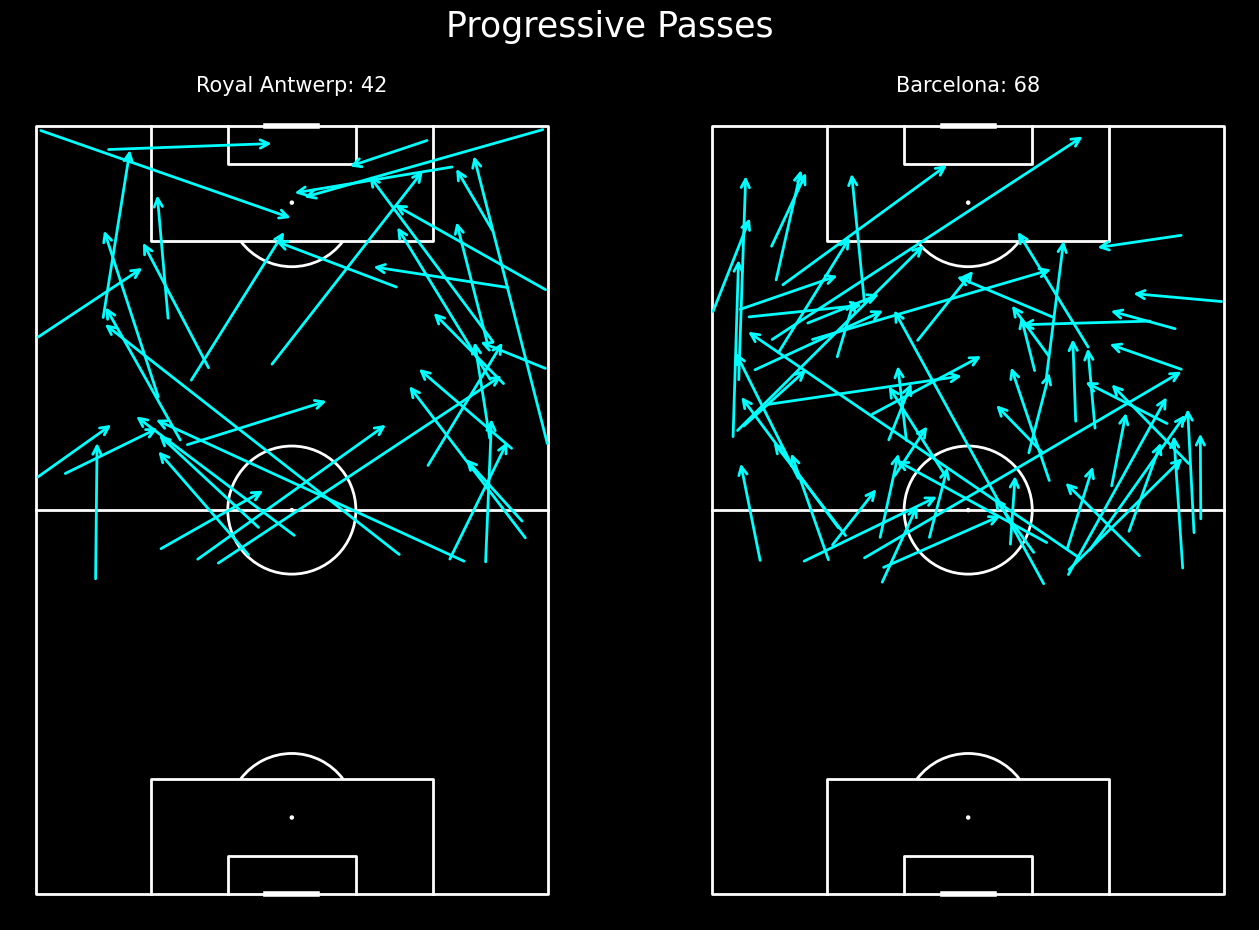

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mplsoccer.pitch import VerticalPitch

# Create two separate figures and axes with a black background
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 11), facecolor='#000000')

# Create a function to draw the shot maps
def draw_progressive_pass_map(ax, df, title):
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#000000', line_color='#ffffff')
    pitch.draw(ax=ax)
    ax.invert_xaxis()  # Invert the x-axis

    progressive_count = 0
    for index, row in df.iterrows():
        if row['pro'] >= 9.144:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=15, color='cyan', linewidth=2)
            ax.add_patch(arrow)
            progressive_count += 1

    counttext = f"{title}: {progressive_count}"
    ax.set_title(counttext, color='white', fontsize=15)

# Draw the progressive pass map for Shakhtar
draw_progressive_pass_map(ax1, dfhpp, hteamName)

# Draw the progressive pass map for Barcelona
draw_progressive_pass_map(ax2, dfapp, ateamName)

plt.suptitle("Progressive Passes", fontsize=25, color='white', y=0.95)
# Display the combined plot
plt.show()

# Zone14 & Halfspaces

---



In [ ]:
dfhp = df.loc[df['teamId_x'] == hteamID]
dfhp = dfhp.loc[dfhp['type'] == "Pass"]
dfhp = dfhp.loc[dfhp['outcomeType'] == "Successful"]

dfap = df.loc[df['teamId_x'] == ateamID]
dfap = dfap.loc[dfap['type'] == "Pass"]
dfap = dfap.loc[dfap['outcomeType'] == "Successful"]

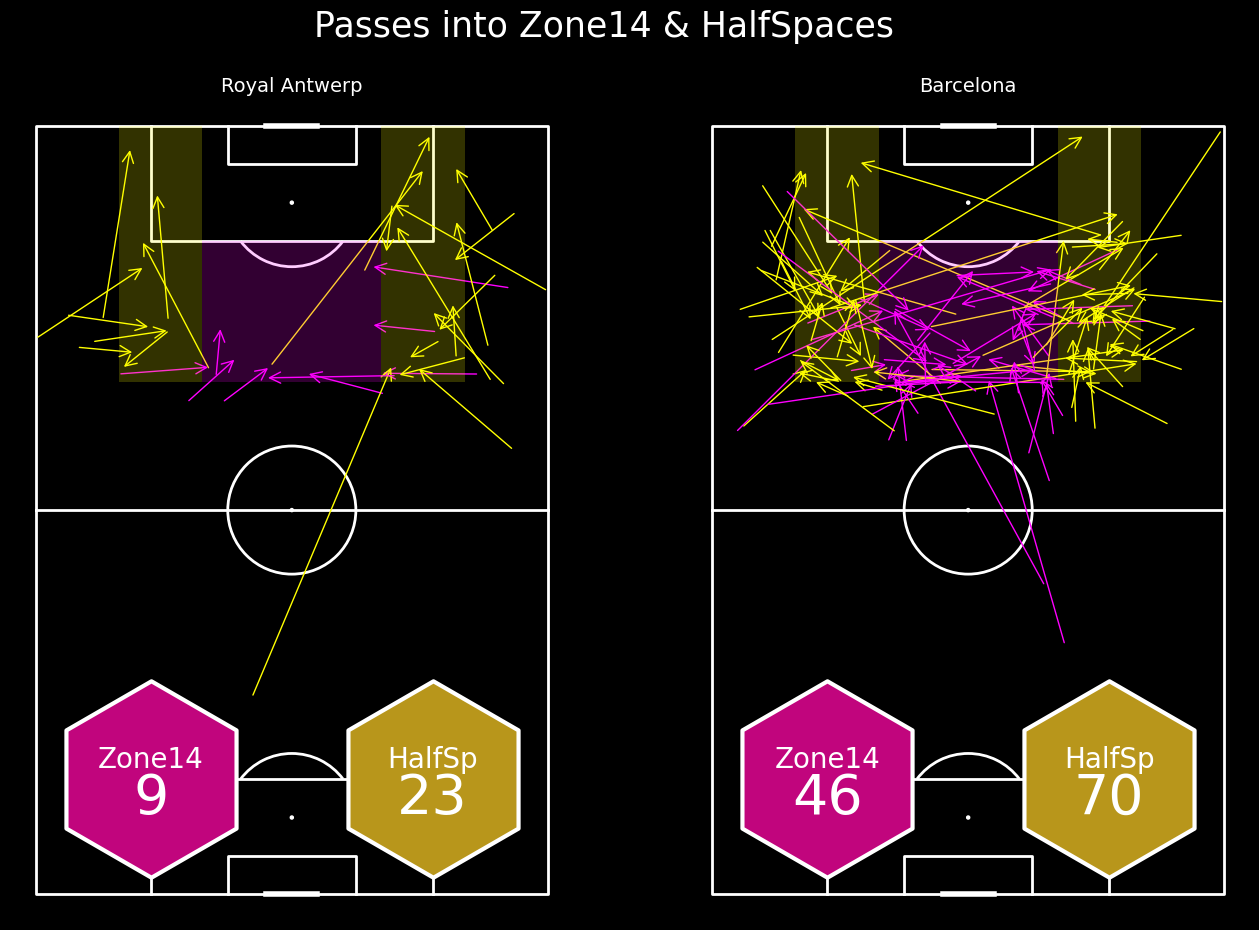

In [ ]:
# Create a figure with a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 11), facecolor='#000000')

# Create a function to draw the shot maps
def draw_pass_map(ax, df, title):
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#000000', line_color='#ffffff')
    pitch.draw(ax=ax)
    ax.invert_xaxis()
    ax.set_facecolor('#000000')


    z14 = 0
    hs = 0

    for index, row in df.iterrows():
        if row['endY'] >= 80 and row['endY'] <= 102 and row['endX'] >= 26 and row['endX'] <= 54:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='magenta', linewidth=1)
            ax.add_patch(arrow)
            z14 += 1
        if row['endY'] >= 80 and row['endX'] >= 13 and row['endX'] <= 26:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='yellow', linewidth=1)
            ax.add_patch(arrow)
            hs += 1
        if row['endY'] >= 80 and row['endX'] >= 54 and row['endX'] <= 67:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='yellow', linewidth=1)
            ax.add_patch(arrow)
            hs += 1

    x_z14 = [26, 26, 54, 54]
    y_z14 = [80, 102, 102, 80]
    ax.fill(x_z14, y_z14, 'magenta', alpha=0.2, label='Zone14')

    x_rhs = [13, 13, 26, 26]
    y_rhs = [80, 120, 120, 80]
    ax.fill(x_rhs, y_rhs, 'yellow', alpha=0.2, label='HalfSpaces')

    x_lhs = [54, 54, 67, 67]
    y_lhs = [80, 120, 120, 80]
    ax.fill(x_lhs, y_lhs, 'yellow', alpha=0.2, label='HalfSpaces')

    z14name = "Zone14"
    hsname = "HalfSp"
    z14count = f"{z14}"
    hscount = f"{hs}"
    ax.scatter(18, 18, color='#b8961b', s=20000, edgecolor='white', linewidth=3, alpha=1, marker='h')
    ax.scatter(62, 18, color='#c1057d', s=20000, edgecolor='white', linewidth=3, alpha=1, marker='h')
    ax.text(18, 21, hsname, fontsize=20, color='white', ha='center', va='center')
    ax.text(62, 21, z14name, fontsize=20, color='white', ha='center', va='center')
    ax.text(18, 15, hscount, fontsize=40, color='white', ha='center', va='center')
    ax.text(62, 15, z14count, fontsize=40, color='white', ha='center', va='center')
    ax.set_title(title, color='white', fontsize=14)

# Draw the first shot map
draw_pass_map(axs[0], dfhp, hteamName)

# Draw the second shot map
draw_pass_map(axs[1], dfap, ateamName)


plt.suptitle("Passes into Zone14 & HalfSpaces ", fontsize=25, color='white', y=0.95)
# Display the combined plot
plt.show()

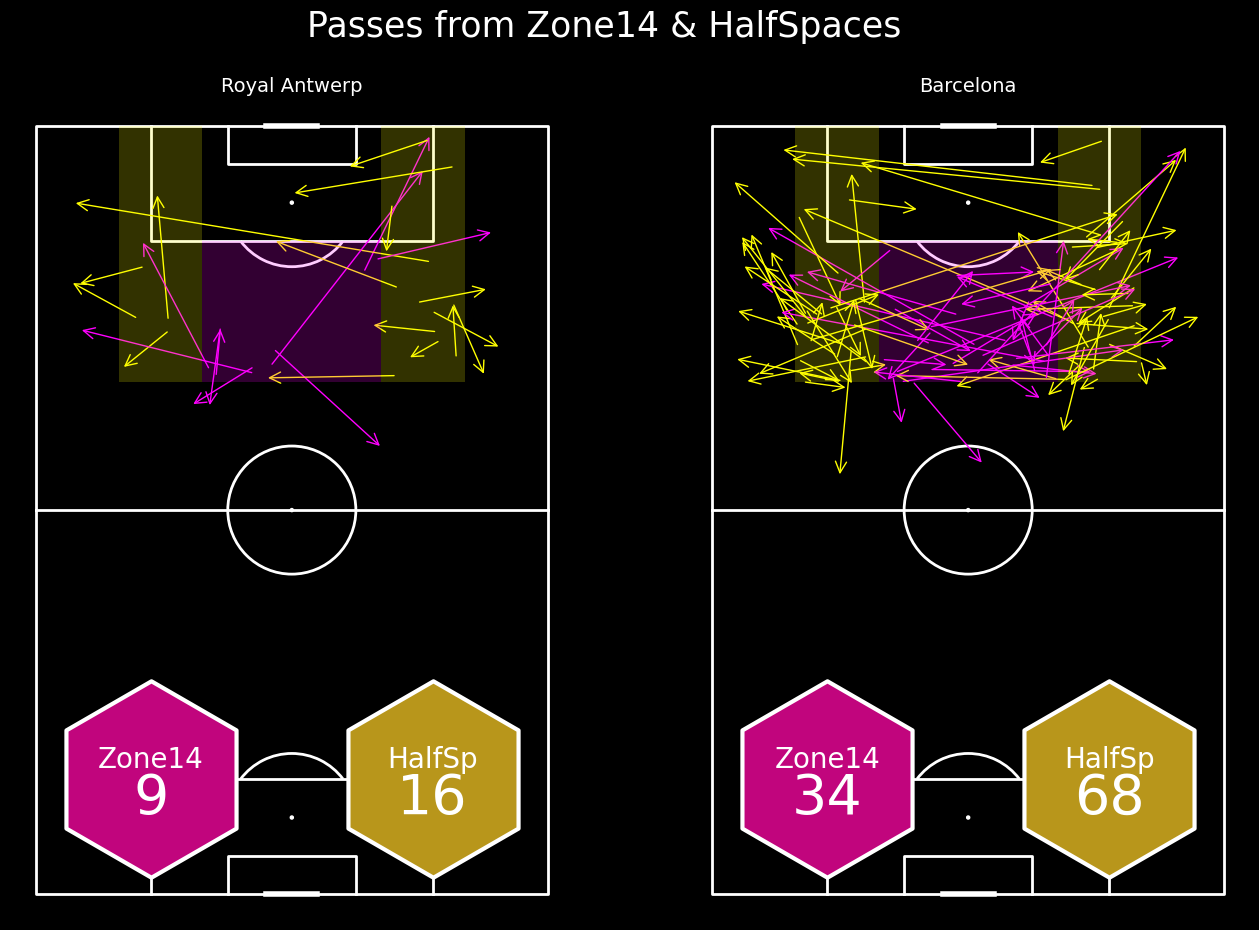

In [ ]:
# Create a figure with a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 11), facecolor='#000000')

# Create a function to draw the shot maps
def draw_shot_map(ax, df, title):
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#000000', line_color='#ffffff')
    pitch.draw(ax=ax)
    ax.invert_xaxis()
    ax.set_facecolor('#000000')

    z14 = 0
    hs = 0

    for index, row in df.iterrows():
        if row['y'] >= 80 and row['y'] <= 102 and row['x'] >= 26 and row['x'] <= 54:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='magenta', linewidth=1)
            ax.add_patch(arrow)
            z14 += 1
        if row['y'] >= 80 and row['x'] >= 13 and row['x'] <= 26:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='yellow', linewidth=1)
            ax.add_patch(arrow)
            hs += 1
        if row['y'] >= 80 and row['x'] >= 54 and row['x'] <= 67:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='yellow', linewidth=1)
            ax.add_patch(arrow)
            hs += 1

    x_z14 = [26, 26, 54, 54]
    y_z14 = [80, 102, 102, 80]
    ax.fill(x_z14, y_z14, 'magenta', alpha=0.2, label='Zone14')

    x_rhs = [13, 13, 26, 26]
    y_rhs = [80, 120, 120, 80]
    ax.fill(x_rhs, y_rhs, 'yellow', alpha=0.2, label='HalfSpaces')

    x_lhs = [54, 54, 67, 67]
    y_lhs = [80, 120, 120, 80]
    ax.fill(x_lhs, y_lhs, 'yellow', alpha=0.2, label='HalfSpaces')

    z14name = "Zone14"
    hsname = "HalfSp"
    z14count = f"{z14}"
    hscount = f"{hs}"
    ax.scatter(18, 18, color='#b8961b', s=20000, edgecolor='white', linewidth=3, alpha=1, marker='h')
    ax.scatter(62, 18, color='#c1057d', s=20000, edgecolor='white', linewidth=3, alpha=1, marker='h')
    ax.text(18, 21, hsname, fontsize=20, color='white', ha='center', va='center')
    ax.text(62, 21, z14name, fontsize=20, color='white', ha='center', va='center')
    ax.text(18, 15, hscount, fontsize=40, color='white', ha='center', va='center')
    ax.text(62, 15, z14count, fontsize=40, color='white', ha='center', va='center')
    ax.set_title(title, color='white', fontsize=14)

# Draw the first shot map
draw_shot_map(axs[0], dfhp, hteamName)

# Draw the second shot map
draw_shot_map(axs[1], dfap, ateamName)

plt.suptitle("Passes from Zone14 & HalfSpaces ", fontsize=25, color='white', y=0.95)
# Display the combined plot
plt.show()

# Player PassMap

---



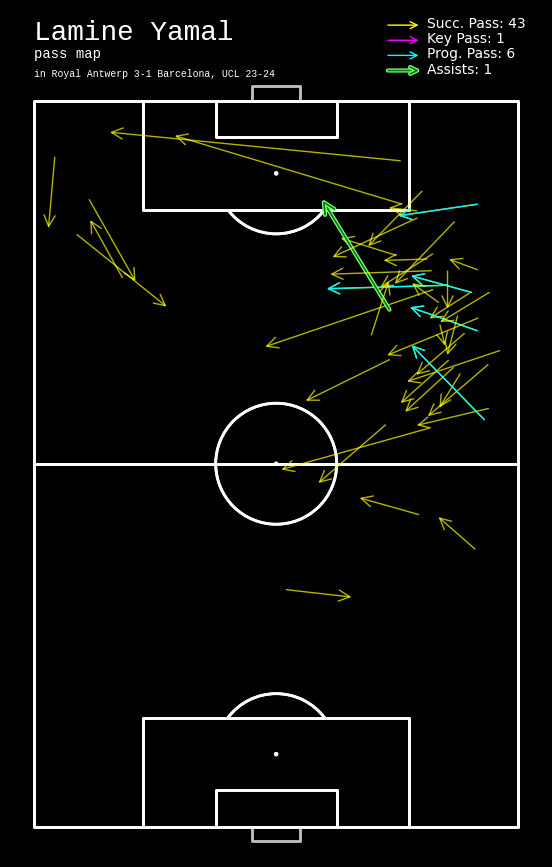

In [ ]:
# Set up the pitch
pitch = VerticalPitch(pitch_type='statsbomb', goal_type='box', goal_alpha=.5, pitch_color='#000000', line_color='#ffffff')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#000000')
pitch.draw(ax=ax)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.ylim(-5, 135)

yellow_arrow_count = 0
green_arrow_count = 0
cyan_arrow_count = 0
magenta_arrow_count = 0



# Plot all the actions
for index, row in df.iterrows():
  if (
     row['name'] == 'Lamine Yamal' and
     row['type'] == 'Pass' and
     row['outcomeType'] == 'Successful'
  ):
     arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='yellow', linewidth=1, alpha=0.7)
     ax.add_patch(arrow)
     yellow_arrow_count += 1

  if (
    row['name'] == 'Lamine Yamal' and
    row['type'] == 'Pass' and
    row['outcomeType'] == 'Successful' and
    (
        (row['pro'] >= 9.144) or
        (row['x'] >= 48 and row['y'] >= 18 and row['y'] <= 62 and row['endX'] >= 102 and row['endY'] >= 18 and row['endY'] <= 62)
    )
  ):
    arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='cyan', linewidth=1)
    ax.add_patch(arrow)
    cyan_arrow_count += 1

  if (
    row['name'] == 'Lamine Yamal' and
    row['type'] == 'Pass' and
    row['outcomeType'] == 'Successful' and
    'KeyPass' in row['qualifiers']
  ):
    arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='magenta', linewidth=1)
    ax.add_patch(arrow)
    magenta_arrow_count += 1

  if (
    row['name'] == 'Lamine Yamal' and
    row['type'] == 'Pass' and
    row['outcomeType'] == 'Successful' and
    'IntentionalGoalAssist' in row['qualifiers']
  ):
    arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='green', linewidth=1)
    arrow.set_path_effects([withStroke(linewidth=3, foreground='#80ff80'), Normal()])
    ax.add_patch(arrow)
    green_arrow_count += 1

  if (
     row['name'] == 'Lamine Yamal' and
     row['type'] == 'Goal'
  ):
     arrow = patches.FancyArrowPatch((row['x'], row['y']), (37,120), arrowstyle='->', mutation_scale=1, color='green', linewidth=2, alpha=0.7)
     ax.add_patch(arrow)
     plt.scatter(row['x'], row['y'], color='green', s=100, marker='*')

# Add custom text under the plot
count_lines = [
    f"Succ. Pass: {yellow_arrow_count}",
    f"Key Pass: {magenta_arrow_count}",
    f"Prog. Pass: {cyan_arrow_count}",
    f"Assists: {green_arrow_count}",
]
# Add custom text lines for counts under the plot
y_coordinate = 132
for line in count_lines:
    plt.text(15, y_coordinate, line, fontsize=10, color='white', ha='left')
    y_coordinate -= 2.5

Title = "Lamine Yamal"
font = FontProperties(family='Liberation Mono', style='normal', size=20)
plt.text(80, 130, Title, fontproperties=font, color='white')
Subtitle = "pass map"
font = FontProperties(family='Liberation Mono', style='normal', size=10)
plt.text(80, 127, Subtitle, fontproperties=font, color='white')
Subtitle = f"in {hteamName} 3-1 {ateamName}, UCL 23-24"
font = FontProperties(family='Liberation Mono', style='normal', size=7)
plt.text(80, 124, Subtitle, fontproperties=font, color='white')


arrow = patches.FancyArrowPatch((22, 132.5), (16, 132.5), arrowstyle='->', mutation_scale=12.5, color='yellow', linewidth=1)
ax.add_patch(arrow)
arrow = patches.FancyArrowPatch((22, 130), (16, 130), arrowstyle='->', mutation_scale=12.5, color='magenta', linewidth=1)
ax.add_patch(arrow)
arrow = patches.FancyArrowPatch((22,127.5), (16, 127.5), arrowstyle='->', mutation_scale=12.5, color='cyan', linewidth=1)
ax.add_patch(arrow)
arrow = patches.FancyArrowPatch((22,125), (16, 125), arrowstyle='->', mutation_scale=12.5, color='green', linewidth=1)
arrow.set_path_effects([withStroke(linewidth=3, foreground='#80ff80'), Normal()])
ax.add_patch(arrow)


# TouchMap

---



In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming df is your DataFrame
# # df = ...

# # Assuming x and y are numeric columns and isTouch is boolean
# # Example:
# # df = pd.DataFrame({'x': [10, 20, 30, 40, 50],
# #                    'y': [5, 15, 25, 35, 45],
# #                    'isTouch': [True, False, True, True, False]})

# # Create an empty 2D grid
# grid = [[False] * 12 for _ in range(8)]

# # Update the grid based on the 'isTouch' column in your DataFrame
# for _, row in df.iterrows():
#     if row['isTouch']:
#         # Assuming x and y are in the range 0-120 and 0-80 respectively
#         x_index = int(row['x'] / 10)
#         y_index = int(row['y'] / 10)
#         grid[y_index][x_index] = True

# # Create a DataFrame from the grid
# heatmap_df = pd.DataFrame(grid)

# # Create a Seaborn heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(heatmap_df, cmap='coolwarm', cbar=False)
# plt.title('Touch Heatmap')
# plt.show()


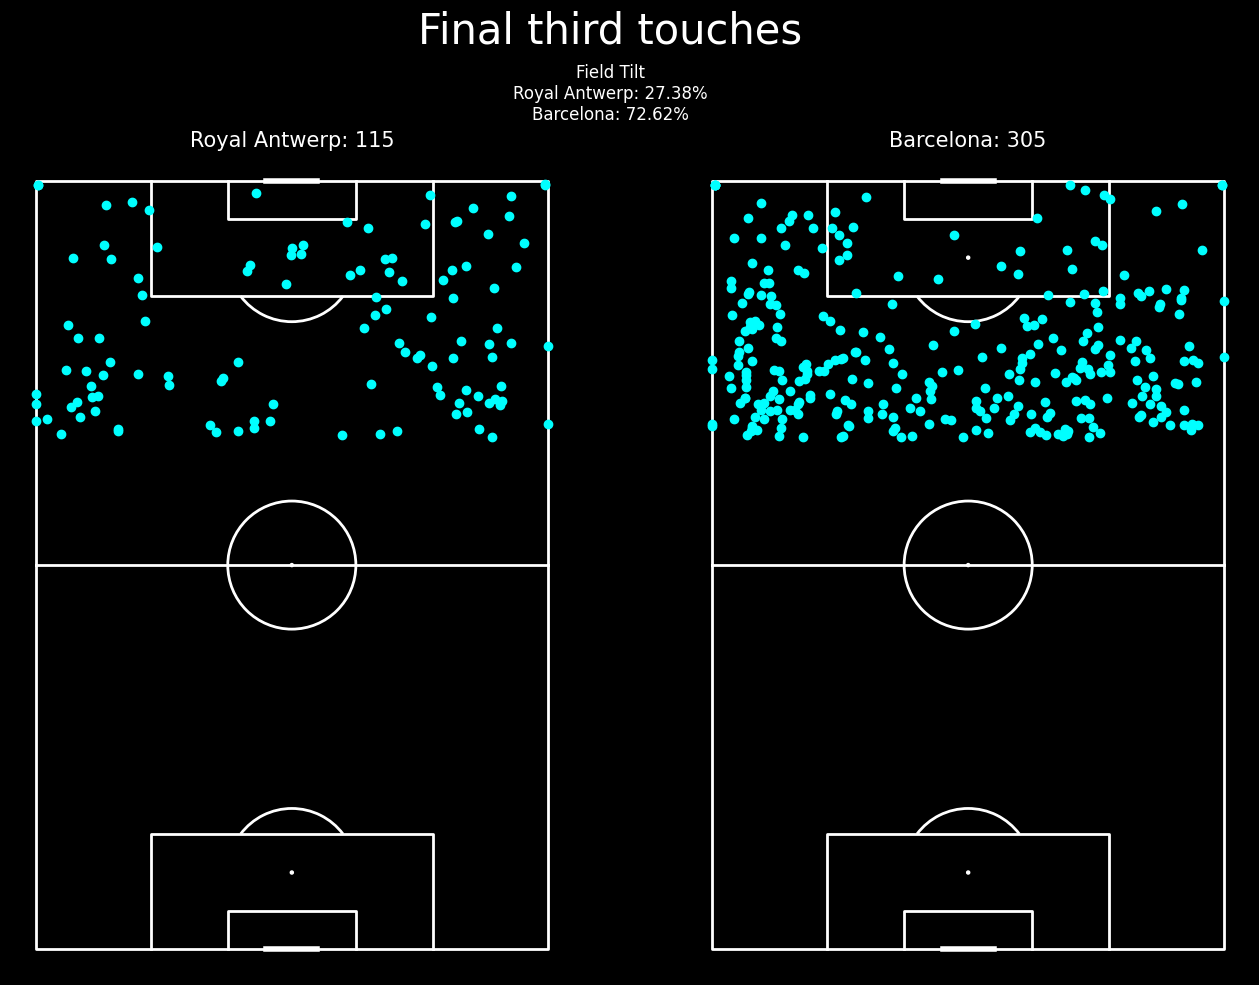

In [ ]:
mask_h = (df['teamId_x'] == hteamID) & (df['isTouch'] == 1) & (df['y'] >= 80)
dfthdh = df[mask_h]

mask_a = (df['teamId_x'] == ateamID) & (df['isTouch'] == 1) & (df['y'] >= 80)
dfthda = df[mask_a]

import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 11), facecolor='#000000')

def Final_third_touch_map(ax, df, title):
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#000000', line_color='#ffffff')
    pitch.draw(ax=ax)

    final_third_count = len(df)
    for index, row in df.iterrows():
        ax.scatter(row['x'], row['y'], color='cyan')

    counttext = f"{title}: {final_third_count}"
    ax.set_title(counttext, color='white', fontsize=15)

    ax.invert_xaxis()

Final_third_touch_map(ax1, dfthdh, hteamName)
Final_third_touch_map(ax2, dfthda, ateamName)

total_touches = len(df[df['isTouch'] == 1] [df['y'] >= 80])
percentage_h = (len(dfthdh) / total_touches) * 100
percentage_a = (len(dfthda) / total_touches) * 100

plt.suptitle("Final third touches", fontsize=30, color='white', y=1)
plt.figtext(0.5, 0.9, f"Field Tilt\n{hteamName}: {percentage_h:.2f}%\n{ateamName}: {percentage_a:.2f}%", ha='center', color='white', fontsize=12)

plt.show()

# ScatterPCPP
---



In [ ]:
pip install adjustText

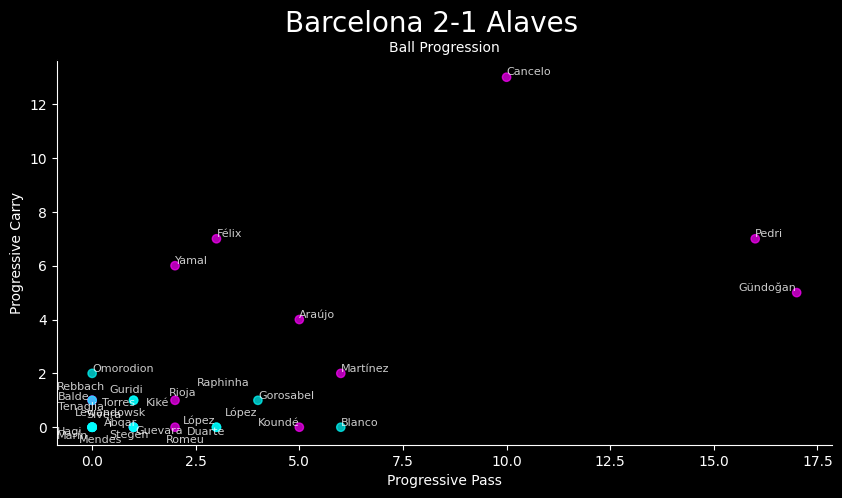

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from adjustText import adjust_text  # Import the adjust_text module

# Create a colormap
colors = {'Barcelona': 'magenta', 'Alaves': 'cyan'}

fig, ax = plt.subplots(figsize=(10, 5))
fig.set_facecolor('black')
ax.patch.set_facecolor('black')

# Create DataFrame
dfCP = pd.read_csv('/content/fcbalaPCPP.csv')
# Sort the DataFrame based on 'PrgC' in descending order
dfC_sorted = dfCP.sort_values(by='PrgC', ascending=False)
# Sort the DataFrame based on 'PrgP' in descending order
dfP_sorted = dfCP.sort_values(by='PrgP', ascending=False)

# Plot the scatter plot with color based on 'Team' column
scatter = plt.scatter(dfCP['PrgP'], dfCP['PrgC'], c=dfCP['team'].map(colors), alpha=0.7)

# Add labels for all players with text wrapping
labels = [textwrap.fill(txt.split()[-1], width=10) for txt in dfCP['Player']]  # Use string splitting to get the last part
texts = [plt.text(x, y, label, color='white', alpha=0.8, fontsize=8) for x, y, label in zip(dfCP['PrgP'], dfCP['PrgC'], labels)]

# Adjust text positions to minimize overlap
adjust_text(texts, force_points=0.1, force_text=0.1, expand_points=(1, 1), expand_text=(1, 1))

# Add labels and title
plt.xlabel('Progressive Pass', color='white', fontsize=10)
plt.ylabel('Progressive Carry', color='white', fontsize=10)
plt.suptitle('Barcelona 2-1 Alaves', color='white', fontsize=20)
plt.title('Ball Progression', color='white', fontsize=10)

# Set the color of the x and y axis lines
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text  # Import the adjust_text module

fig, ax = plt.subplots(figsize=(16,9))
fig.set_facecolor('black')
ax.patch.set_facecolor('black')

# Create DataFrame
dfxG = pd.read_csv('/content/top5leagueXG - Sheet1.csv')
# Sort the DataFrame based on 'xG' in descending order
dfxG_sorted = dfxG.sort_values(by='xG', ascending=False)
# Sort the DataFrame based on 'xGA' in descending order
dfxGA_sorted = dfxG.sort_values(by='xGA', ascending=False)

# Plot the scatter plot with color based on 'Team' column
scatter = plt.scatter(dfxG['xGA'], dfxG['xG'], s=50, c='red', alpha=0.8)

# Add labels for all Teams without text wrapping
texts = [plt.text(x, y, label, color='white', alpha=0.8, fontsize=12) for x, y, label in zip(dfxG['xGA'], dfxG['xG'], dfxG['Team'])]

# Adjust text positions to minimize overlap
adjust_text(texts, force_points=0.1, force_text=0.1, expand_points=(1, 1), expand_text=(1, 1))

# Add labels and title
plt.xlabel('Expected Goals Against(xGA)', color='white', fontsize=20)
plt.ylabel('Expected Goals(xG)', color='white', fontsize=20)
plt.suptitle('Teams performance in Top 5 League 23-24', color='white', fontsize=35, ha='center')
plt.title('according to xG and xGA', color='white', fontsize=17, ha='center')

# Set the color of the x and y axis lines
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Set ticks along the x-axis spine at specific intervals
x_ticks = np.arange(dfxG['xGA'].min() - 2, dfxG['xGA'].max() + 2, 2)
ax.set_xticks(x_ticks)
ax.xaxis.tick_bottom()  # Move ticks to the bottom for better visibility
ax.tick_params(axis='x', colors='white')  # Set tick color

# Set ticks along the y-axis spine at specific intervals
y_ticks = np.arange(dfxG['xG'].min() - 2, dfxG['xG'].max() + 2, 3)
ax.set_yticks(y_ticks)
ax.yaxis.tick_left()  # Move ticks to the left for better visibility
ax.tick_params(axis='y', colors='white')  # Set tick color

# Plot dotted lines at the average xG and xGA values
avg_xG = dfxG['xG'].mean()
avg_xGA = dfxG['xGA'].mean()

ax.axvline(x=avg_xGA, color='white', linestyle='--', alpha=0.25, linewidth=1, label=f'Average xGA ({avg_xGA:.2f})')
ax.axhline(y=avg_xG, color='white', linestyle='--', alpha=0.25, linewidth=1, label=f'Average xG ({avg_xG:.2f})')
ax.text(dfxG['xGA'].min()-1, dfxG['xG'].max()+1, "Good Attack\nGood Defense", fontsize=10, color='white', alpha=0.5)
ax.text(dfxG['xGA'].min()-1, dfxG['xG'].min()+1, "Bad Attack\nGood Defense", fontsize=10, color='white', alpha=0.5)
ax.text(dfxG['xGA'].max()+1, dfxG['xG'].max()+1, "Good Attack\nBad Defense", fontsize=10, color='white', alpha=0.5)
ax.text(dfxG['xGA'].max()+1, dfxG['xG'].min()+1, "Bad Attack\nBad Defense", fontsize=10, color='white', alpha=0.5)


plt.show()

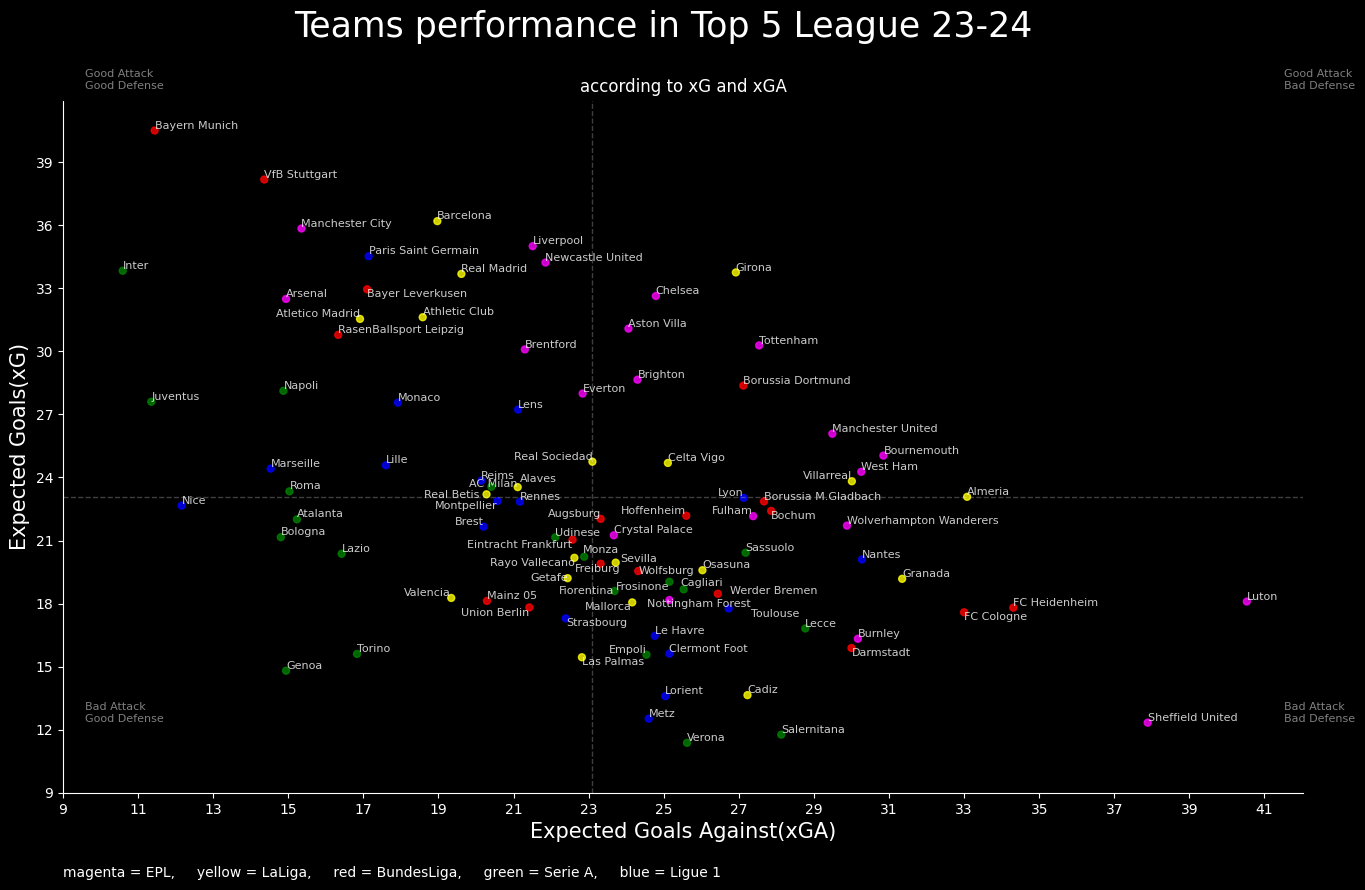

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text  # Import the adjust_text module

fig, ax = plt.subplots(figsize=(16,9))
fig.set_facecolor('black')
ax.patch.set_facecolor('black')

# Create DataFrame
dfxG = pd.read_csv('/content/top5leagueXG - Sheet1.csv')
# Sort the DataFrame based on 'xG' in descending order
dfxG_sorted = dfxG.sort_values(by='xG', ascending=False)
# Sort the DataFrame based on 'xGA' in descending order
dfxGA_sorted = dfxG.sort_values(by='xGA', ascending=False)

# Define colors based on the 'League' column
colors = np.where(dfxG['League'].str.contains('ger'), 'red', 'blue')
colors = np.where(dfxG['League'].str.contains('esp'), 'yellow', colors)
colors = np.where(dfxG['League'].str.contains('fra'), 'blue', colors)
colors = np.where(dfxG['League'].str.contains('ita'), 'green', colors)
colors = np.where(dfxG['League'].str.contains('eng'), 'magenta', colors)

# Plot the scatter plot with color based on 'Team' column
scatter = plt.scatter(dfxG['xGA'], dfxG['xG'], s=25, c=colors, alpha=0.8)

# Add labels for all Teams without text wrapping
texts = [plt.text(x, y, label, color='white', alpha=0.8, fontsize=8) for x, y, label in zip(dfxG['xGA'], dfxG['xG'], dfxG['Team'])]

# Adjust text positions to minimize overlap
adjust_text(texts, force_points=0.1, force_text=0.1, expand_points=(1, 1), expand_text=(1, 1))

# Add labels and title
plt.xlabel('Expected Goals Against(xGA)', color='white', fontsize=15)
plt.ylabel('Expected Goals(xG)', color='white', fontsize=15)
plt.suptitle('Teams performance in Top 5 League 23-24', color='white', fontsize=25, ha='center')
plt.title('according to xG and xGA', color='white', fontsize=12, ha='center')

# Set the color of the x and y axis lines
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Set ticks along the x-axis spine at specific intervals
# x_ticks = np.arange(dfxG['xGA'].min() - 2, dfxG['xGA'].max() + 2, 2)
x_ticks = np.arange(9, 43, 2)
ax.set_xticks(x_ticks)
ax.xaxis.tick_bottom()  # Move ticks to the bottom for better visibility
ax.tick_params(axis='x', colors='white')  # Set tick color

# Set ticks along the y-axis spine at specific intervals
# y_ticks = np.arange(dfxG['xG'].min() - 2, dfxG['xG'].max() + 2, 3)
y_ticks = np.arange(9, 41, 3)
ax.set_yticks(y_ticks)
ax.yaxis.tick_left()  # Move ticks to the left for better visibility
ax.tick_params(axis='y', colors='white')  # Set tick color

# Plot dotted lines at the average xG and xGA values
avg_xG = dfxG['xG'].mean()
avg_xGA = dfxG['xGA'].mean()

ax.axvline(x=avg_xGA, color='white', linestyle='--', alpha=0.25, linewidth=1, label=f'Average xGA ({avg_xGA:.2f})')
ax.axhline(y=avg_xG, color='white', linestyle='--', alpha=0.25, linewidth=1, label=f'Average xG ({avg_xG:.2f})')
ax.text(dfxG['xGA'].min()-1, dfxG['xG'].max()+2, "Good Attack\nGood Defense", fontsize=8, color='white', alpha=0.5)
ax.text(dfxG['xGA'].min()-1, dfxG['xG'].min()+1, "Bad Attack\nGood Defense", fontsize=8, color='white', alpha=0.5)
ax.text(dfxG['xGA'].max()+1, dfxG['xG'].max()+2, "Good Attack\nBad Defense", fontsize=8, color='white', alpha=0.5)
ax.text(dfxG['xGA'].max()+1, dfxG['xG'].min()+1, "Bad Attack\nBad Defense", fontsize=8, color='white', alpha=0.5)

plt.text(9,5, "magenta = EPL,     yellow = LaLiga,     red = BundesLiga,     green = Serie A,     blue = Ligue 1", color='white')

plt.show()

# Events Heatmap

---



In [ ]:
mask = df['teamId_x'] == hteamID
dfhome = df[mask]
dfhome = dfhome.loc[dfhome['isTouch'] == 1]
mask = df['teamId_x'] == ateamID
dfaway = df[mask]
dfaway = dfaway.loc[dfaway['isTouch'] == 1]

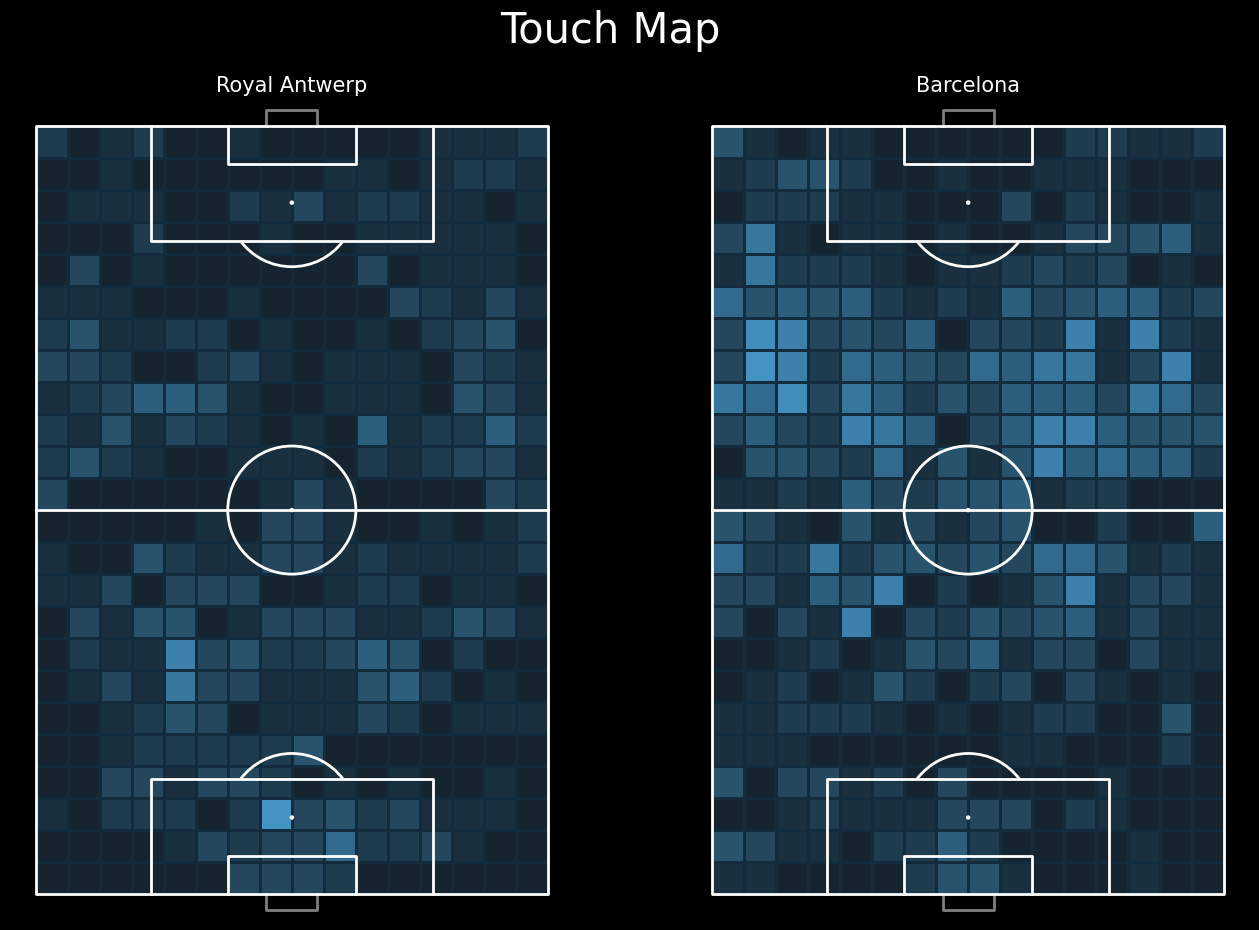

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 11), facecolor='#000000')

def Touch_map(ax, df, title):
    pitch = VerticalPitch(line_color='#ffffff', goal_type='box', goal_alpha=.5, line_zorder=2, pitch_color='#000000')
    pitch.draw(ax=ax)

    pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", ['#15242e', '#4393c4'], N=20)

    bs = pitch.bin_statistic(df.y, df.x, bins=(24, 16))
    heatmap = pitch.heatmap(bs, edgecolors='#122c3d', ax=ax, cmap=pearl_earring_cmap)
    teamName = title
    ax.set_title(teamName, color='white', fontsize=15)
    ax.invert_xaxis()

Touch_map(ax1, dfhome, hteamName)
Touch_map(ax2, dfaway, ateamName)

plt.suptitle("Touch Map", fontsize=30, color='white', y=0.95)

plt.show()
